In [ ]:
!pip -q install xgboost lightgbm tensorflow networkx plotly scikit-learn==1.5.1

In [ ]:
import os, math, ssl, smtplib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
sns.set(style="whitegrid")


In [ ]:
DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df_raw = pd.read_csv(DATA_URL)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# 1) Drop exact duplicates (if any)
df = df_raw.drop_duplicates()
# 2) Handle missing values (this dataset has none, but keep for completeness)
df = df.fillna(method="ffill").fillna(method="bfill")


In [ ]:

# Time-derived features (dataset 'Time' is seconds from first transaction)
df["hour"] = (df["Time"] // 3600) % 24   # transaction hour of the day

# Log transformation of Amount to reduce skewness
df["amount_log"] = np.log1p(df["Amount"])

# Robust z-score for Amount (robust against outliers)
df["amount_robust_z"] = (df["Amount"] - df["Amount"].median()) / (df["Amount"].quantile(0.75) - df["Amount"].quantile(0.25))

# Check results
print(df.head())
print(df[["Amount", "amount_log", "amount_robust_z"]].head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V24       V25       V26       V27       V28  \
0  0.098698  0.363787  ...  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1  0.085102 -0.255425  ... -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.247676 -1.514654  ... -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.377436 -1.387024  ... -1.175575  0.647376 -0.221929  0.062723  0.061458   
4 -0.270533  0.817739  ...  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  hour  amount_l

In [ ]:
df["customer_id"] = (df["Time"].astype(int) % 20000).astype(str).radd("C")
df["merchant_id"] = (df["Amount"].round().astype(int) % 500).astype(str).radd("M")

print("Engineered columns added:", {"hour","amount_log","amount_robust_z","amount_bin","customer_id","merchant_id"})


Engineered columns added: {'amount_robust_z', 'customer_id', 'amount_log', 'amount_bin', 'hour', 'merchant_id'}


In [ ]:
# 3) Train/Test split + Scaling
TARGET = "Class"
drop_cols = [TARGET, "customer_id", "merchant_id"]  # keep synthetic IDs out of ML features

X = df.drop(columns=drop_cols, errors="ignore")
y = df[TARGET].astype(int)

num_cols = X.columns  # all are numeric here
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (198608, 33) (85118, 33)


LogisticRegression  ROC-AUC: 0.9676 | PR-AUC: 0.6934
DecisionTree       ROC-AUC: 0.8555 | PR-AUC: 0.5489
RandomForest       ROC-AUC: 0.9548 | PR-AUC: 0.8224
XGBoost            ROC-AUC: 0.9749 | PR-AUC: 0.8253
[LightGBM] [Info] Number of positive: 331, number of negative: 198277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8185
[LightGBM] [Info] Number of data points in the train set: 198608, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

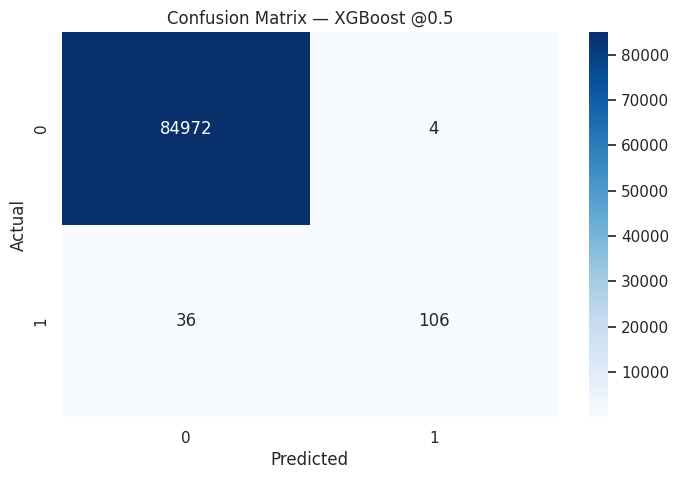

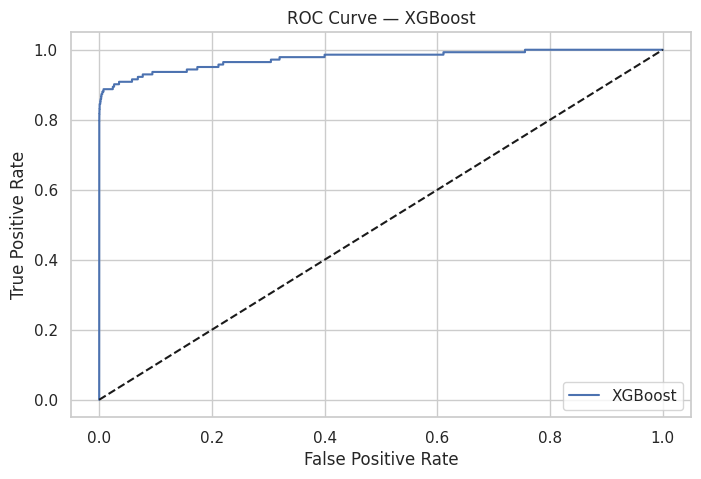

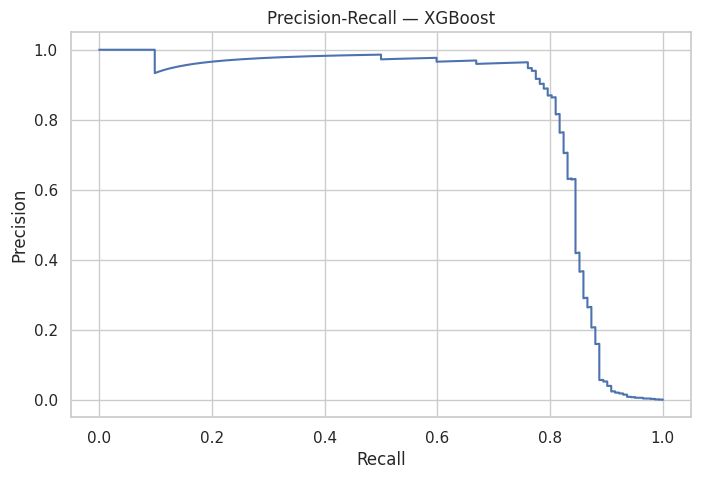

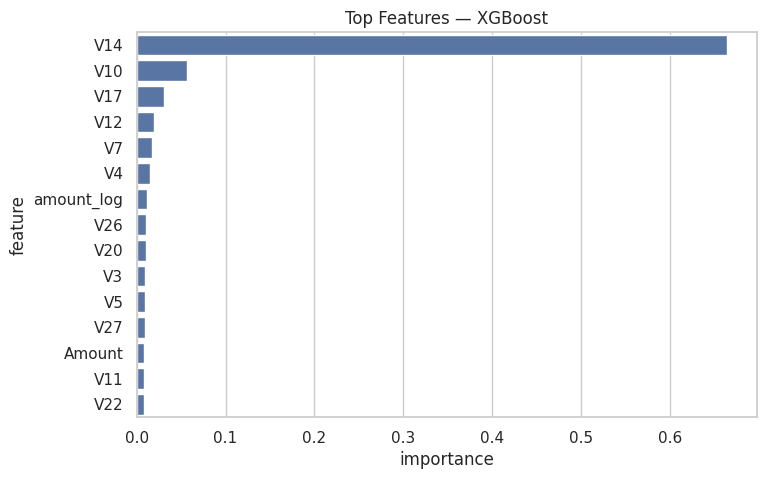

In [ ]:
# 4) Supervised Models (5 algorithms)

supervised_models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1),
    "DecisionTree":      DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "RandomForest":      RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", n_jobs=-1, random_state=42),
    "XGBoost":           XGBClassifier(
                            n_estimators=400, max_depth=6, learning_rate=0.08,
                            subsample=0.9, colsample_bytree=0.9,
                            eval_metric="logloss", tree_method="hist", random_state=42
                         ),
    "LightGBM":          LGBMClassifier(
                            n_estimators=500, learning_rate=0.05,
                            num_leaves=64, subsample=0.9, colsample_bytree=0.9,
                            class_weight="balanced", random_state=42
                         ),
}

sup_results = {}
proba_store = {}

for name, model in supervised_models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    proba_store[name] = proba
    roc = roc_auc_score(y_test, proba)
    prauc = average_precision_score(y_test, proba)
    sup_results[name] = {"ROC-AUC": roc, "PR-AUC": prauc}
    print(f"{name:17s}  ROC-AUC: {roc:.4f} | PR-AUC: {prauc:.4f}")

# Pick the best supervised model by PR-AUC (more relevant under extreme imbalance)
best_sup = max(sup_results, key=lambda k: sup_results[k]["PR-AUC"])
print("\nBest supervised model by PR-AUC:", best_sup, sup_results[best_sup])

# Confusion matrix at default threshold 0.5 for the best model
from sklearn.metrics import confusion_matrix
y_pred_best = (proba_store[best_sup] >= 0.5).astype(int)
print("\nClassification report (best supervised @0.5):")
print(classification_report(y_test, y_pred_best, digits=4))

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_sup} @0.5")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ROC + PR curves for best model
fpr, tpr, _ = roc_curve(y_test, proba_store[best_sup])
prec, rec, _ = precision_recall_curve(y_test, proba_store[best_sup])

plt.plot(fpr, tpr, label=best_sup)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {best_sup}")
plt.legend(); plt.show()

plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision-Recall — {best_sup}")
plt.show()

# Feature importance (tree models only)
if best_sup in ["RandomForest", "XGBoost", "LightGBM"]:
    model_best = supervised_models[best_sup]
    if hasattr(model_best, "feature_importances_"):
        imp = model_best.feature_importances_
        fi = pd.DataFrame({"feature": X.columns, "importance": imp}).sort_values("importance", ascending=False).head(15)
        sns.barplot(data=fi, x="importance", y="feature")
        plt.title(f"Top Features — {best_sup}")
        plt.show()

IsolationForest  ROC-AUC: 0.9434898436940605
IsolationForest  PR-AUC : 0.08166285083383094
OneClassSVM      ROC-AUC: 0.9367952442578651
OneClassSVM      PR-AUC : 0.09433193837846338
Epoch 1/5
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7891 - val_loss: 0.3889
Epoch 2/5
776/776 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3303 - val_loss: 0.2676
Epoch 3/5
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2479 - val_loss: 0.2339
Epoch 4/5
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2156 - val_loss: 0.1961
Epoch 5/5
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1887 - val_loss: 0.1776
Autoencoder      ROC-AUC: 0.9138494945383085
Autoencoder      PR-AUC : 0.08549286517818042


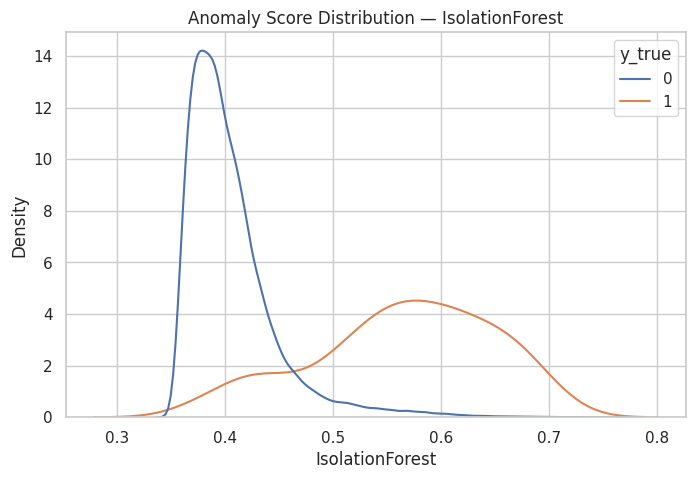

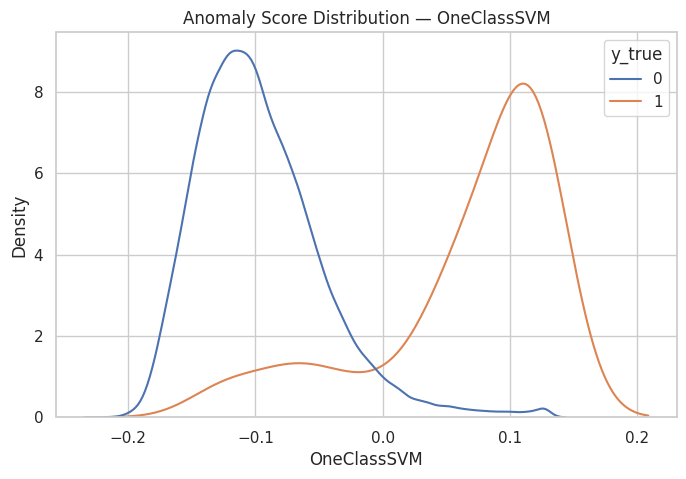

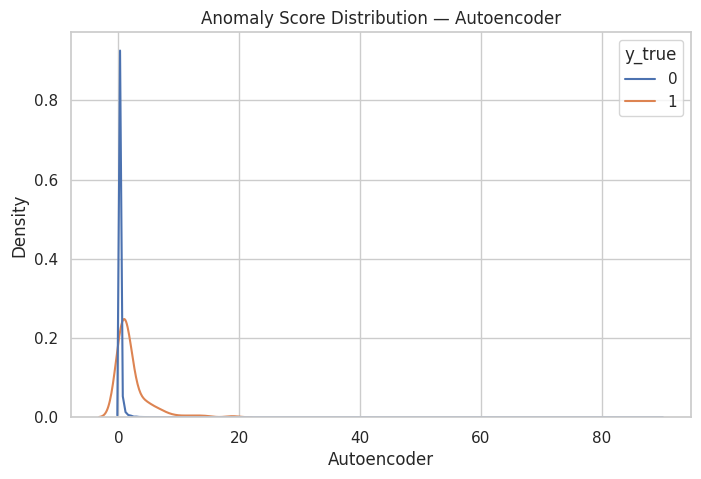

In [ ]:
# 5) Unsupervised Anomaly Detection

# Isolation Forest (scores: higher => more anomalous)
iso = IsolationForest(n_estimators=400, contamination=0.002, random_state=42)
iso.fit(X_train)
iso_scores = -iso.score_samples(X_test)  # invert so higher is more anomalous
print("IsolationForest  ROC-AUC:", roc_auc_score(y_test, iso_scores))
print("IsolationForest  PR-AUC :", average_precision_score(y_test, iso_scores))

# One-Class SVM (decision_function: higher => more normal; invert for anomaly)
oc = OneClassSVM(kernel="rbf", nu=0.002, gamma="scale")
oc.fit(X_train[:10000])  # subset for speed
oc_scores = -oc.decision_function(X_test)  # invert for anomaly
print("OneClassSVM      ROC-AUC:", roc_auc_score(y_test, oc_scores))
print("OneClassSVM      PR-AUC :", average_precision_score(y_test, oc_scores))

# Autoencoder (reconstruction error as anomaly score)
input_dim = X_train.shape[1]
inp = Input(shape=(input_dim,))
enc = Dense(32, activation="relu",
            activity_regularizer=regularizers.l1(1e-6))(inp)
enc = Dense(16, activation="relu")(enc)
dec = Dense(32, activation="relu")(enc)
out = Dense(input_dim, activation="linear")(dec)
autoenc = Model(inputs=inp, outputs=out)
autoenc.compile(optimizer="adam", loss="mse")

hist = autoenc.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=5, batch_size=256, shuffle=True, verbose=1
)

recon = autoenc.predict(X_test, verbose=0)
mse = np.mean((X_test - recon)**2, axis=1)
print("Autoencoder      ROC-AUC:", roc_auc_score(y_test, mse))
print("Autoencoder      PR-AUC :", average_precision_score(y_test, mse))

# Compare unsupervised scores visually
score_df = pd.DataFrame({
    "IsolationForest": iso_scores,
    "OneClassSVM": oc_scores,
    "Autoencoder": mse,
    "y_true": y_test.to_numpy()
})
for col in ["IsolationForest","OneClassSVM","Autoencoder"]:
    sns.kdeplot(data=score_df, x=col, hue="y_true", common_norm=False)
    plt.title(f"Anomaly Score Distribution — {col}")
    plt.show()


In [ ]:
# Build bipartite graph customer <-> merchant (synthetic)
# Use a manageable subset to keep it quick
gdf = df.sample(8000, random_state=42)[["customer_id","merchant_id","Amount","Class"]].copy()

G = nx.Graph()
for r in gdf.itertuples(index=False):
    # weight by amount; keep fraud label on edge
    G.add_edge(r.customer_id, r.merchant_id, weight=float(r.Amount), is_fraud=int(r.Class))

print("Graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

# Simple analytics
deg = dict(G.degree())
top_nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top-degree nodes:", top_nodes)

# Community detection (greedy modularity)
communities = list(nx.algorithms.community.greedy_modularity_communities(G))
print("Communities detected:", len(communities))

# Flag communities with higher fraud edge ratio
community_scores = []
for idx, comm in enumerate(communities):
    sub = G.subgraph(comm)
    if sub.number_of_edges() == 0:
        continue
    fraud_edges = sum(1 for _,_,d in sub.edges(data=True) if d.get("is_fraud",0)==1)
    ratio = fraud_edges / sub.number_of_edges()
    community_scores.append((idx, sub.number_of_nodes(), sub.number_of_edges(), ratio))

comm_df = pd.DataFrame(community_scores, columns=["community","nodes","edges","fraud_edge_ratio"]).sort_values("fraud_edge_ratio", ascending=False)
comm_df.head()

px.bar(comm_df.head(15), x="community", y="fraud_edge_ratio", title="Communities with Highest Fraud-Edge Ratio").show()


Graph nodes: 6990 edges: 7965
Top-degree nodes: [('M1', 901), ('M2', 427), ('M10', 291), ('M4', 201), ('M12', 195), ('M5', 174), ('M15', 173), ('M20', 172), ('M9', 163), ('M3', 158)]
Communities detected: 163


In [ ]:
best_model = supervised_models[best_sup]
best_scores = proba_store[best_sup]

ALERT_THRESHOLD = 0.90  # tune to control alert volume

# Minimal email alert function:
def send_alert_email(tx, score, threshold=ALERT_THRESHOLD):
    """
    This prints in Colab for safety.
    To actually send email via Gmail:
      - Turn on 2FA for your Gmail
      - Create an App Password
      - Set env vars: ALERT_SENDER, ALERT_APP_PASSWORD, ALERT_RECIPIENTS
    """
    print(f"🚨 ALERT | tx_id={tx['tx_id']} amount={tx['Amount']:.2f} score={score:.3f} loc={tx.get('Location','N/A')}")

    # --- Real email (commented) ---
    """
    SENDER = os.getenv("ALERT_SENDER")
    APP_PW = os.getenv("ALERT_APP_PASSWORD")
    RECIPS = os.getenv("ALERT_RECIPIENTS","risk-team@example.com").split(",")

    if not (SENDER and APP_PW):
        return

    msg = f""" + '"""' + """
[FRAUD ALERT]
Transaction ID: {tx['tx_id']}
Amount: {tx['Amount']}
Score: {score:.4f}  (threshold {threshold})
""" + '"""' + """
    ctx = ssl.create_default_context()
    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls(context=ctx)
        server.login(SENDER, APP_PW)
        server.sendmail(SENDER, RECIPS, msg)
    """

# Build a small "stream" from a slice of X_test and y_test
stream_df = pd.DataFrame(X_test, columns=X.columns).copy()
stream_df["score"] = best_scores
stream_df["y_true"] = y_test.to_numpy()
# make a fake tx_id and location to display
stream_df["tx_id"] = np.arange(len(stream_df))
stream_df["Location"] = np.where((stream_df["hour"]>=20)|(stream_df["hour"]<=5),"Night","Day")
stream_df["Amount"] = df.loc[y_test.index, "Amount"].to_numpy()

# Simulate streaming in mini-batches
BATCH = 1000
alerts = []
for start in range(0, len(stream_df), BATCH):
    batch = stream_df.iloc[start:start+BATCH]
    # Raise alerts
    for r in batch.itertuples(index=False):
        if r.score >= ALERT_THRESHOLD:
            alerts.append((r.tx_id, float(r.score), int(r.y_true), float(r.Amount), r.Location))
            send_alert_email(r._asdict(), r.score)

print(f"\nTotal alerts raised @ threshold {ALERT_THRESHOLD}: {len(alerts)}")


🚨 ALERT | tx_id=680 amount=130.21 score=0.999 loc=Night
🚨 ALERT | tx_id=821 amount=45.51 score=1.000 loc=Night
🚨 ALERT | tx_id=1812 amount=10.70 score=0.999 loc=Night
🚨 ALERT | tx_id=1899 amount=1.00 score=0.992 loc=Night
🚨 ALERT | tx_id=2765 amount=219.80 score=0.999 loc=Night
🚨 ALERT | tx_id=3394 amount=118.30 score=1.000 loc=Night
🚨 ALERT | tx_id=4048 amount=1.63 score=0.999 loc=Night
🚨 ALERT | tx_id=5126 amount=318.11 score=1.000 loc=Night
🚨 ALERT | tx_id=5165 amount=4.97 score=1.000 loc=Night
🚨 ALERT | tx_id=5923 amount=109.90 score=1.000 loc=Night
🚨 ALERT | tx_id=6594 amount=0.00 score=0.955 loc=Night
🚨 ALERT | tx_id=7623 amount=1354.25 score=0.997 loc=Night
🚨 ALERT | tx_id=7624 amount=99.99 score=0.973 loc=Night
🚨 ALERT | tx_id=8240 amount=802.52 score=0.983 loc=Night
🚨 ALERT | tx_id=9085 amount=84.28 score=0.988 loc=Night
🚨 ALERT | tx_id=10815 amount=99.99 score=0.995 loc=Night
🚨 ALERT | tx_id=12189 amount=1.00 score=0.964 loc=Night
🚨 ALERT | tx_id=13777 amount=111.70 score=1.0

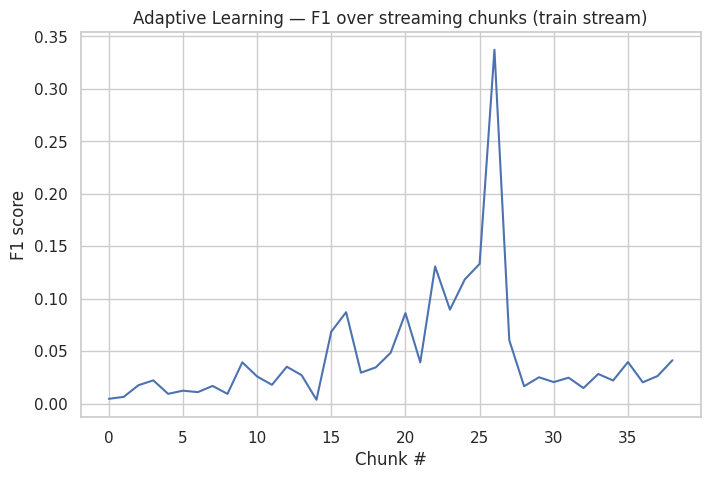

SGD (adaptive) ROC-AUC: 0.935722157507273
SGD (adaptive) PR-AUC : 0.017932134792749306


In [ ]:
# 8) Adaptive Learning (simple demo)
# We'll use SGDClassifier (logistic loss) as an online learner
from sklearn.utils.class_weight import compute_class_weight

sgd = SGDClassifier(loss="log_loss", random_state=42)
classes = np.array([0,1])

# Initialize on a small warm-up set
warm_X, warm_y = X_train[:5000], y_train[:5000]

# Compute class weights for the warm-up set
warm_weights = compute_class_weight('balanced', classes=classes, y=warm_y)
class_weight_dict = {0: warm_weights[0], 1: warm_weights[1]}

sgd.partial_fit(warm_X, warm_y, classes=classes, sample_weight=np.array([class_weight_dict[i] for i in warm_y]))

# Stream remaining data in chunks and adapt
from sklearn.metrics import f1_score
chunk = 5000
f1_scores = []
for start in range(5000, len(X_train), chunk):
    Xb = X_train[start:start+chunk]
    yb = y_train[start:start+chunk]
    if len(yb)==0: break

    # Compute class weights for the current chunk
    chunk_weights = compute_class_weight('balanced', classes=classes, y=yb)
    chunk_weight_dict = {0: chunk_weights[0], 1: chunk_weights[1]}

    yhat = (sgd.predict_proba(Xb)[:,1] >= 0.5).astype(int)
    f1_scores.append(f1_score(yb, yhat))
    # update model with new labels and sample weights
    sgd.partial_fit(Xb, yb, sample_weight=np.array([chunk_weight_dict[i] for i in yb]))


plt.plot(f1_scores)
plt.title("Adaptive Learning — F1 over streaming chunks (train stream)")
plt.xlabel("Chunk #"); plt.ylabel("F1 score")
plt.show()

# Evaluate online model on held-out test set
sgd_proba = sgd.predict_proba(X_test)[:,1]
print("SGD (adaptive) ROC-AUC:", roc_auc_score(y_test, sgd_proba))
print("SGD (adaptive) PR-AUC :", average_precision_score(y_test, sgd_proba))



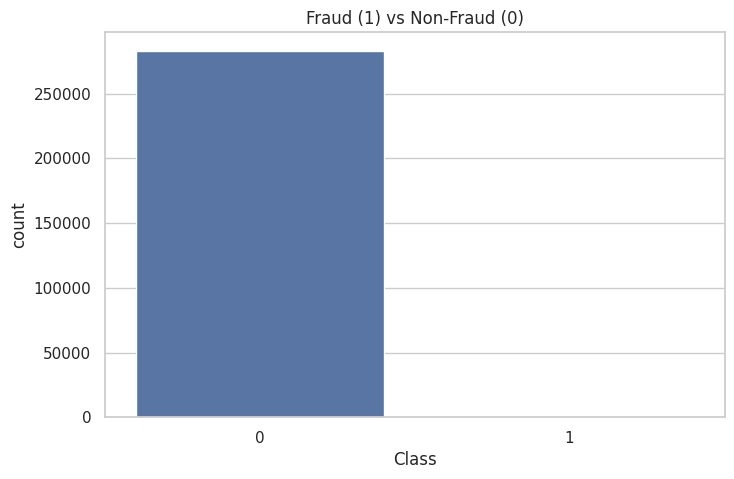

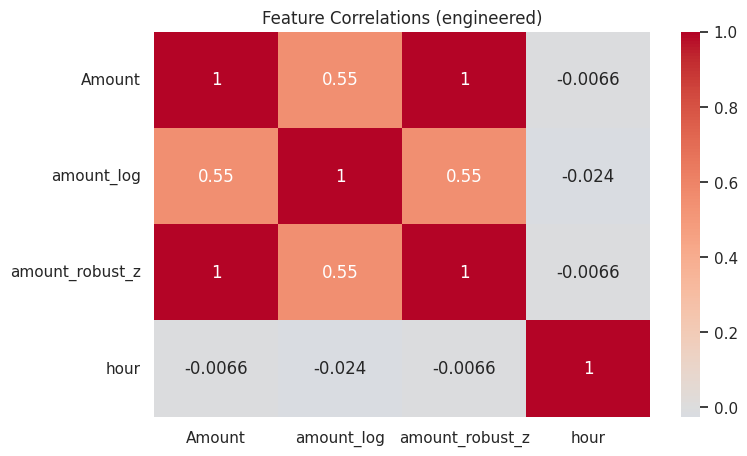

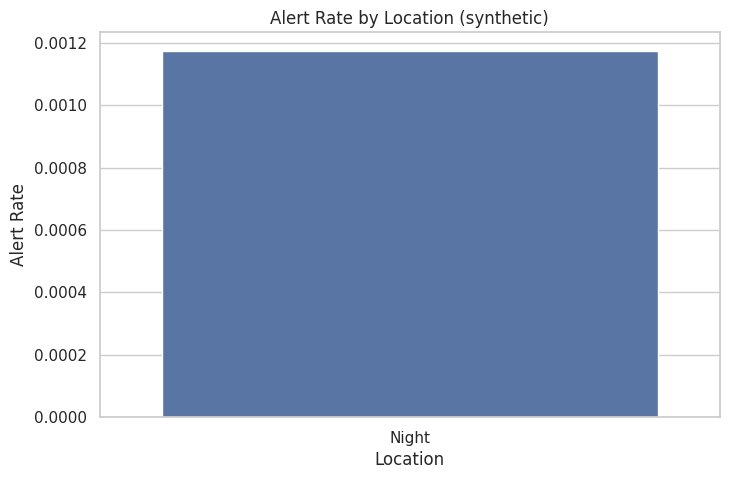

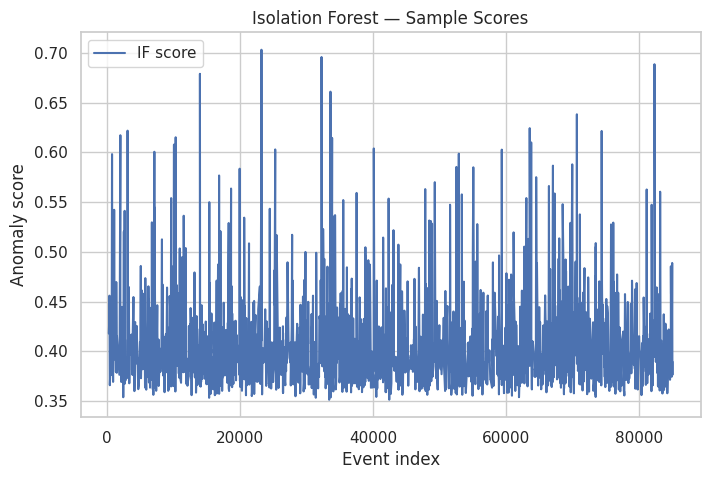

In [ ]:
# 9) Dashboard-style Reporting

# Imbalance chart
sns.countplot(x=df["Class"])
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()

# Heatmap: correlation of engineered features
corr = df[["Amount","amount_log","amount_robust_z","hour"]].corr() # removed 'amount_bin' as it doesn't exist in df
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlations (engineered)")
plt.show()

# Bar: top alerting 'Location' buckets (synthetic)
tmp = stream_df.copy()
tmp["is_alert"] = (tmp["score"]>=ALERT_THRESHOLD).astype(int)
loc_bar = tmp.groupby("Location")["is_alert"].mean().reset_index()
sns.barplot(data=loc_bar, x="Location", y="is_alert")
plt.title("Alert Rate by Location (synthetic)")
plt.ylabel("Alert Rate")
plt.show()

# Anomaly score line sample
sample_scores = score_df.sample(2000, random_state=42).sort_index()
plt.plot(sample_scores.index, sample_scores["IsolationForest"], label="IF score")
plt.xlabel("Event index"); plt.ylabel("Anomaly score"); plt.title("Isolation Forest — Sample Scores")
plt.legend(); plt.show()
